In [1]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-hfbnsc0k
  Stored in directory: /tmp/pip-ephem-wheel-cache-tr_hg919/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from efficientnet import EfficientNetB3

Using TensorFlow backend.


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

### Train data

In [4]:
ann_file = '../input/inaturalist-2019-fgvc6/train2019.json'
with open(ann_file) as data_file:
        train_anns = json.load(data_file)

In [5]:
train_anns_df = pd.DataFrame(train_anns['annotations'])[['image_id','category_id']]
train_img_df = pd.DataFrame(train_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id')
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)
df_train_file_cat.head()

,image_id,file_name,category_id
0,0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,400
1,1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,570
2,2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,167
3,3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,254
4,4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,739


In [6]:
len(df_train_file_cat['category_id'].unique())

1010

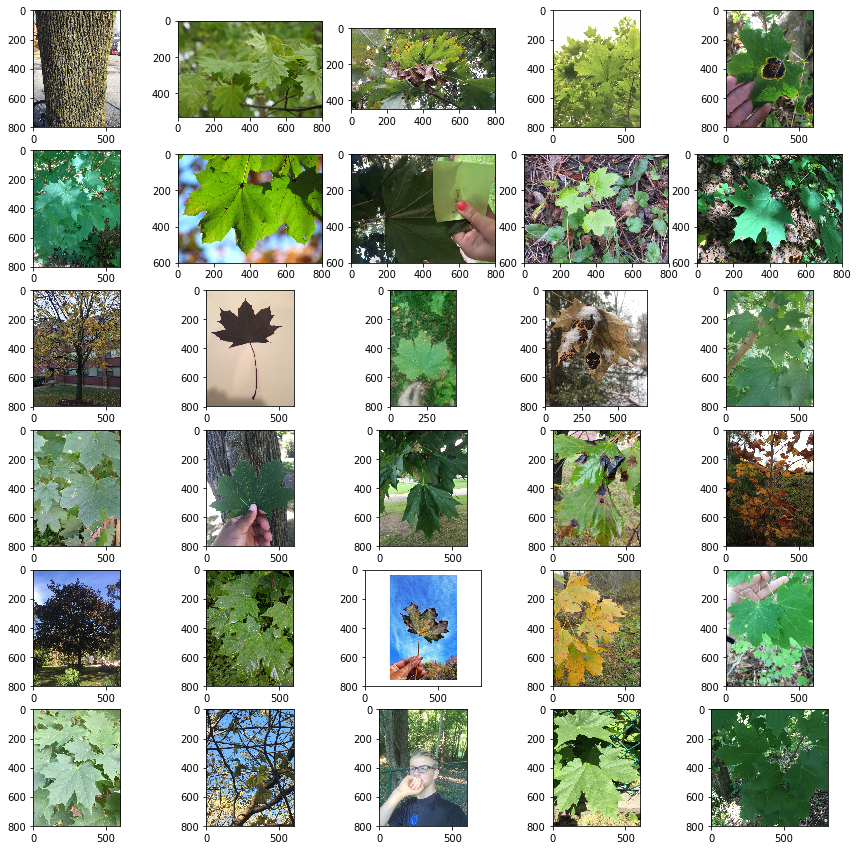

In [7]:
# Example of images for category_id = 400
img_names = df_train_file_cat[df_train_file_cat['category_id']=='400']['file_name'][:30]

plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("../input/inaturalist-2019-fgvc6/train_val2019/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

### Validation data

In [8]:
valid_ann_file = '../input/inaturalist-2019-fgvc6/val2019.json'
with open(valid_ann_file) as data_file:
        valid_anns = json.load(data_file)

In [9]:
valid_anns_df = pd.DataFrame(valid_anns['annotations'])[['image_id','category_id']]
valid_anns_df.head()

,image_id,category_id
0,265213,644
1,265214,597
2,265215,883
3,265216,300
4,265217,881


In [10]:
valid_img_df = pd.DataFrame(valid_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
valid_img_df.head()

,image_id,file_name
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...


In [11]:
df_valid_file_cat = pd.merge(valid_img_df, valid_anns_df, on='image_id')
df_valid_file_cat['category_id']=df_valid_file_cat['category_id'].astype(str)
df_valid_file_cat.head()

,image_id,file_name,category_id
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...,644
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...,597
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...,883
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...,300
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...,881


In [12]:
nb_classes = 1010
batch_size = 256
img_size = 96
nb_epochs = 10

In [13]:
%%time
train_datagen=ImageDataGenerator(rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )

train_generator=train_datagen.flow_from_dataframe(    
    dataframe=df_train_file_cat,    
    directory="../input/inaturalist-2019-fgvc6/train_val2019",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 265213 images belonging to 1010 classes.
CPU times: user 3.4 s, sys: 6.03 s, total: 9.44 s
Wall time: 41.1 s


In [14]:
%%time
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=test_datagen.flow_from_dataframe(    
    dataframe=df_valid_file_cat,    
    directory="../input/inaturalist-2019-fgvc6/train_val2019",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 3030 images belonging to 1010 classes.
CPU times: user 32 ms, sys: 80 ms, total: 112 ms
Wall time: 416 ms


### Model

In [15]:
model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
43974656/43966704 [==============================] - 2s 0us/step


In [16]:
model.trainable = False

In [17]:
# Freeze some layers
# for layer in model.layers[:-4]:
#     layer.trainable = False

In [18]:
#Adding custom layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [19]:
# Callbacks

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [20]:
%%time
history = model_final.fit_generator(generator=train_generator,  
                                    
                                    steps_per_epoch=5,
                                    
                                    validation_data=valid_generator, 
                                    
                                    validation_steps=2,
                                    
                                    epochs=nb_epochs,
                                    callbacks = [checkpoint, early],
                                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 44s - loss: 7.2508 - acc: 7.8125e-04 - val_loss: 7.0851 - val_acc: 0.0020

Epoch 00001: val_loss improved from inf to 7.08512, saving model to vgg16_1.h5
Epoch 2/10
 - 4s - loss: 7.1507 - acc: 0.0031 - val_loss: 7.0564 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 7.08512 to 7.05643, saving model to vgg16_1.h5
Epoch 3/10
 - 4s - loss: 7.2046 - acc: 0.0016 - val_loss: 7.0570 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 7.05643
Epoch 4/10
 - 20s - loss: 7.0902 - acc: 7.8125e-04 - val_loss: 7.0295 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 7.05643 to 7.02947, saving model to vgg16_1.h5
Epoch 5/10
 - 26s - loss: 7.0863 - acc: 0.0000e+00 - val_loss: 6.9757 - val_acc: 0.0000e+00

Epoch 00005: val_loss improved from 7.02947 to 6.97572, saving model to vgg16_1.h5
Epoch 6/10
 - 26s - loss: 7.0095 - acc: 0.0031 - val_loss: 6.9849 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not imp

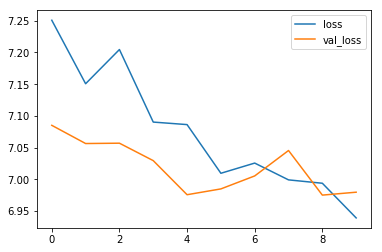

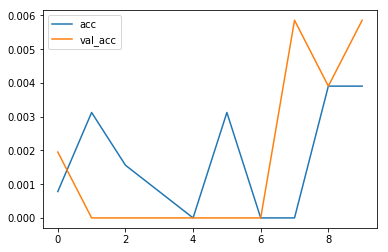

In [21]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

### Test data

In [22]:
test_ann_file = '../input/inaturalist-2019-fgvc6/test2019.json'
with open(test_ann_file) as data_file:
        test_anns = json.load(data_file)

In [23]:
test_img_df = pd.DataFrame(test_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
test_img_df.head()

,image_id,file_name
0,268243,test2019/e295f3c7046b1f1e80c0301401324aa9.jpg
1,268244,test2019/ad3dcbb6846ed0b4dab58d7b1a4210ba.jpg
2,268245,test2019/e697be8e296b4b140cff4f96f85c364f.jpg
3,268246,test2019/7e7ba55e6aa26ba99e814d63b15d0121.jpg
4,268247,test2019/6cb6372079d23702511c06923970f13f.jpg


In [24]:
%%time

test_generator = test_datagen.flow_from_dataframe(      
    
        dataframe=test_img_df,    
    
        directory = "../input/inaturalist-2019-fgvc6/test2019",    
        x_col="file_name",
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 35350 images.
CPU times: user 7.28 s, sys: 852 ms, total: 8.14 s
Wall time: 7.34 s


### Prediction

In [25]:
%%time
test_generator.reset()
predict=model_final.predict_generator(test_generator, steps = len(test_generator.filenames))

CPU times: user 47min 31s, sys: 35.6 s, total: 48min 6s
Wall time: 40min 25s


In [26]:
len(predict)

35350

In [27]:
predicted_class_indices=np.argmax(predict,axis=1)

In [28]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [29]:
sam_sub_df = pd.read_csv('../input/inaturalist-2019-fgvc6/kaggle_sample_submission.csv')
sam_sub_df.head()

,id,predicted
0,268243,842
1,268244,139
2,268245,988
3,268246,612
4,268247,468


In [30]:
filenames=test_generator.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted":predictions})
df_res = pd.merge(test_img_df, results, on='file_name')[['image_id','predicted']]\
    .rename(columns={'image_id':'id'})

df_res.head()

,id,predicted
0,268243,270
1,268244,325
2,268245,393
3,268246,656
4,268247,124


In [31]:
df_res.to_csv("submission.csv",index=False)